In [2]:
import fnmatch
import os
import random
import re
import threading
import pandas as pd
import time

import librosa
import numpy as np


import matplotlib.pyplot as plt

%matplotlib inline

FILE_PATTERN = r'*.wav'

In [50]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.metrics import log_loss, accuracy_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Load data

In [12]:
def randomize_files(files):
    '''Shuffle loaded files'''
    for file in files:
        file_index = random.randint(0, (len(files) - 1))
        yield files[file_index]


def find_files(directory, pattern='*.wav'):
    '''Recursively finds all files matching the pattern.'''
    files = []
    fnames = []
    for root, dirnames, filenames in os.walk(directory):
        for filename in fnmatch.filter(filenames, pattern):
            files.append(os.path.join(root, filename))
            fnames.append(filename)
    return files, fnames

def get_category(fname):
    '''Parse type from fnamepar'''
    return fname.split('/')[-1].split('_')[0]

def load_generic_audio(files, sample_rate, amount):
    '''Generator that yields audio waveforms from the directory.'''
    for it, filename in enumerate(files):
        if it == amount:
            break
        category_id = get_category(filename)
        audio, _ = librosa.load(filename, sr=sample_rate, mono=True)
        audio = audio.reshape(-1, 1)
        yield audio, filename, category_id

# Второе дополнительное задание !!!
def trim_silence(audio, threshold, frame_length=512):
    '''Removes silence at the beginning and end of a sample.'''
    if audio.size < frame_length:
        frame_length = audio.size
    energy = librosa.feature.rmse(audio, frame_length=frame_length)
    frames = np.nonzero(energy > threshold)
    indices = librosa.core.frames_to_samples(frames)[1]

    # Indices can be an empty array, if the whole audio was background.
    return audio[indices[0]:indices[-1]] if indices.size else audio[0:0]



class AudioReader(object):
    '''Noise audio reader that preprocesses audio files
    and add tham in lists'''

    def __init__(self,
                 audio_dir,
                 sample_rate,
                 silence_threshold=None,
                 sample_size=None,
                 load_size=None):
        self.audio_dir = audio_dir
        self.sample_rate = sample_rate
        self.sample_size = sample_size
        self.silence_threshold = silence_threshold
        self.load_size = load_size
        self.counter = 0
        self.time = time.time()

        # TODO Find a better way to check this and deal with empty audio.
        
        self.files, self.fnames = find_files(audio_dir)
        if not self.files:
            raise ValueError("No audio files found in '{}'.".format(audio_dir))
        self.pred_category = np.full(len(self.files), True)
        if load_size is not None:
            self.data = [0]*load_size
            self.id = [0]*load_size
        else:    
            self.data = [0]*len(self.files)
            self.id = [0]*len(self.files)


    def read(self):
        #Read dataset
        
        iterator = load_generic_audio(self.files, self.sample_rate, self.load_size)
        for audio, filename, category_id in iterator:
            if self.silence_threshold is not None:
                # Remove silence
                audio = trim_silence(audio[:, 0], self.silence_threshold)
                audio = audio.reshape(-1)
                if audio.size == 0:
                    self.pred_category[self.counter]=False


            self.data[self.counter] = audio
            self.id[self.counter] = category_id
            self.counter += 1
            if self.counter % 400 == 0:
                print (time.time() - self.time,self.counter)
        return self

In [13]:
audio_dir = './data_v_7_stc/audio' 
sr = 16000
silence_threshold = 7e-4
audio_reader = AudioReader(audio_dir,sr,silence_threshold=silence_threshold)
audio_reader.read()

28.859813451766968 400
55.600207805633545 800
83.59512448310852 1200
109.73975086212158 1600
140.96851754188538 2000
173.63777685165405 2400
204.54908800125122 2800
234.78837633132935 3200
261.3640329837799 3600
290.186096906662 4000
320.12978315353394 4400
348.68605399131775 4800
377.0192017555237 5200
408.560928106308 5600
438.76555585861206 6000
468.65419149398804 6400
498.41939902305603 6800
529.9439296722412 7200
559.9338881969452 7600
587.935742855072 8000
617.9808473587036 8400
646.3717083930969 8800
675.6868977546692 9200
707.0883450508118 9600
735.058333158493 10000
770.2843551635742 10400
798.5032575130463 10800
824.8467507362366 11200


In [14]:
meta = pd.read_csv('./data_v_7_stc/meta/meta.txt',sep = '\t')
meta.drop(columns=['*','time_start'],inplace=True)
to = {'background':0,'bags':1,'door':2,'keyboard':3,'knocking_door':4,'ring':5,'speech':6,'tool':7}
fr = {0:'background',1:'bags',2:'door',3:'keyboard',4:'knocking_door',5:'ring',6:'speech',7:'tool'}
meta['type'] = meta['type'].map(to)

# Choice of silence_threshold

(1, 91) (46086,) 16000


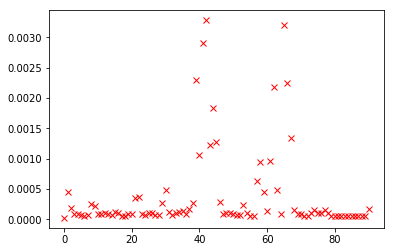

In [153]:
path = './data_v_7_stc/audio/background_0019_time_stretch_13.wav' 
sr = 16000
audio, _ = librosa.load(path, sr=sr, mono=True)
energy = librosa.feature.rmse(audio, frame_length=512)
print (energy.shape, audio.shape, 16000)
plt.plot(energy.reshape(-1), 'rx');

In [116]:
files = find_files('./data_v_7_stc/audio')
files[0].split('/')[-1].split('_')[0]
def get_type(a):
    return a.split('/')[-1].split('_')[0]

In [223]:
s = 0
files = meta[meta['type'] == 0]['fname']
rm = np.zeros((len(files),4))
for i, file in  enumerate(files):
    path = audio_dir + '/' + file
    audio, _ = librosa.load(path, sr=sr, mono=True)
    energy = librosa.feature.rmse(audio, frame_length=512) 
    rm[i] = (energy.max(),energy.mean(),energy.std(),energy.min())
    if energy.max() > s:
        s = energy.max()
plt.hist(rm1[:,1], bins=12)

background_0001.wav 0.00131564
background_0001_time_stretch_5.wav 0.00131575
background_0004.wav 0.00503398
background_0004_time_stretch_1.wav 0.00526163
background_0007.wav 0.00769703
background_0014.wav 0.0453071
background_0014_time_stretch_0.wav 0.0506213
background_0042.wav 0.182996
background_0042_time_stretch_0.wav 0.189449
background_0042_time_stretch_3.wav 0.191987
0.191987


In [190]:
s = 0
files2 = meta[meta['type'] == 1]['fname']
rm2 = np.zeros((len(files2),4))
for i, file in  enumerate(files2):
    path = audio_dir + '/' + file
    audio, _ = librosa.load(path, sr=sr, mono=True)
    energy = librosa.feature.rmse(audio, frame_length=512) 
    rm2[i] = (energy.max(),energy.mean(),energy.std(),energy.min())
    if energy.max() > s:
        s = energy.max()
plt.hist(rm2[:,1], bins=12)

bags_0001.wav 0.0541228
bags_0002.wav 0.24719
bags_0033.wav 0.301132
bags_0033_time_stretch_3.wav 0.310277
bg_0009.wav 0.363868
bg_0010.wav 0.522466
0.522466


# Feature Extraction

## 1.All feature

In [45]:
def extract_feature(X,sample_rate):
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
#     tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    return mfccs,chroma,mel,contrast

In [46]:
n=len(audio_reader.data)
X_train = np.zeros((n,187))
start = time.time()
for i,arr in enumerate(audio_reader.data):
    if arr.size == 0:
        continue
    mfccs, chroma, mel, contrast= extract_feature(arr,sr)
    X_train[i] = np.hstack([mfccs,chroma,mel,contrast])
    if i%200 == 0:
        print (i, time.time()-start)
meta2 = meta.set_index('fname')
files = [0]*len(audio_reader.files)
for i,f in enumerate(audio_reader.files):
    files[i]=f.split('/')[-1]
y_train = np.array(meta2.loc[files]['type'])

0 0.04747128486633301
200 8.350061655044556
400 18.696319103240967


/home/ilya/anaconda3/lib/python3.6/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


600 26.1740620136261
800 34.89454221725464
1000 42.60905718803406
1200 51.508061170578
1400 59.60135817527771
1600 68.4799211025238
1800 77.58724093437195
2000 86.5558967590332
2200 94.39046335220337
2400 106.49810528755188
2600 114.3032660484314
2800 122.66669821739197
3000 130.54872155189514
3200 137.90328097343445
3400 145.56052899360657
3600 155.09582376480103
3800 161.94757461547852
4000 169.0071680545807
4200 175.72693157196045
4400 185.2217402458191
4600 194.28926801681519
4800 202.09439063072205
5200 215.85578227043152
5400 226.63408994674683
5600 235.50754809379578
5800 243.5435860157013
6000 252.72205710411072
6200 260.7970190048218
6400 268.59473419189453
6600 277.7447578907013
6800 285.7484998703003
7000 293.4403862953186
7200 300.8050525188446
7400 309.0696964263916
7600 319.3274357318878
7800 326.24664974212646
8000 335.33339738845825
8200 344.4191460609436
8400 351.74859261512756
8600 359.3136749267578
8800 366.2633123397827
9000 374.2226347923279
9200 383.1863532066345


In [47]:
np.save('y_train',y_train)
np.save('all_features_train',X_train)

In [48]:
test_dir='./data_v_7_stc/test'
test_reader = AudioReader(test_dir,sr,silence_threshold=silence_threshold)
test_reader.read()
n=len(test_reader.data)
X_full = np.zeros((n,187))
start = time.time()
for i,arr in enumerate(test_reader.data):
    if arr.size == 0:
        continue
    mfccs, chroma, mel, contrast= extract_feature(arr,sr)
    X_full[i] = np.hstack([mfccs,chroma,mel,contrast])
    if i%300 == 0:
        print (i, time.time()-start)
to = {'background':0,'bags':1,'door':2,'keyboard':3,'knocking':4,'ring':5,'speech':6,'tool':7}
T = np.array(test_reader.id)
X_test, y_test =X_full[T != 'unknown'],  np.array([to[x] for x in T[T != 'unknown']])
X_unknown = X_full[T == 'unknown']

5.708024740219116 400
0 0.041124820709228516
300 13.464155197143555
600 26.650977849960327


In [49]:
np.save('T',T)
np.save('X_full_test_all_feachers',X_full)

## 2. mfcc only

In [5]:
n=len(audio_reader.data)
X_train = np.zeros((n,40))
start = time.time()
for i,arr in enumerate(audio_reader.data):
    if arr.size == 0:
        continue
    X_train[i]=np.mean(librosa.feature.mfcc(arr,sr,n_mfcc=40).T,axis=0)
    if i%500 == 0:
        print (i, time.time()-start)
meta2 = meta.set_index('fname')
files = [0]*len(audio_reader.files)
for i,f in enumerate(audio_reader.files):
    files[i]=f.split('/')[-1]
y_train = np.array(meta2.loc[files]['type'])

0 0.5690793991088867
300 3.9329147338867188
600 7.083946943283081
900 10.372597455978394
1200 13.718027114868164
1500 16.815144300460815
1800 20.376691579818726
2100 23.496838808059692
2400 27.453993797302246
2700 30.653042554855347
3000 33.998536109924316
3300 37.16329765319824
3600 40.7586989402771
3900 43.51349639892578
4200 46.29870820045471
4500 50.039504051208496
4800 53.13438534736633
5100 55.83721947669983
5400 59.722572803497314
5700 63.05256175994873
6000 66.35065150260925
6300 69.67478084564209
6600 72.96141409873962
6900 75.98595523834229
7200 78.67790722846985
7500 81.79857611656189
7800 85.05421876907349
8100 88.24935626983643
8400 91.26386260986328
8700 94.3135130405426
9000 97.29276657104492
9300 100.64738750457764
9600 103.97904968261719
9900 107.05752825737
10200 110.43324971199036
10500 113.2438178062439
10800 116.28751158714294
11100 119.23323583602905


NameError: name 'files' is not defined

In [56]:
test_dir='./data_v_7_stc/test'
test_reader = AudioReader(test_dir,sr,silence_threshold=silence_threshold)
test_reader.read()
n=len(test_reader.data)
X_full = np.zeros((n,40))
start = time.time()
for i,arr in enumerate(test_reader.data):
    if arr.size == 0:
        continue
    X_full[i]=np.mean(librosa.feature.mfcc(arr,sr,n_mfcc=40).T,axis=0)
    if i%300 == 0:
        print (i, time.time()-start)
to = {'background':0,'bags':1,'door':2,'keyboard':3,'knocking':4,'ring':5,'speech':6,'tool':7}
T = np.array(test_reader.id)
X_test, y_test =X_full[T != 'unknown'],  np.array([to[x] for x in T[T != 'unknown']])
X_unknown = X_full[T == 'unknown']

0.24065589904785156 100
0.4848320484161377 200
0.7339329719543457 300
0.9544987678527832 400
1.198190450668335 500
1.4346206188201904 600
0 0.011100292205810547
300 4.476659774780273
600 8.003519296646118


# Classification part

In [51]:
def score_model(clf, title):
    kfold = KFold(n_splits=3)
    cv_res = np.mean(cross_val_score(clf, X_train, y_train, cv=kfold, scoring='neg_log_loss'))
    print(title, "Cross_Entropy_Loss: {0:.3f}".format(cv_res))

In [135]:
models = [
    (RandomForestClassifier(max_depth = 10,n_n_estimators = 100,random_state=17), "Случайный лес"),
    (XGBClassifier(max_depth = 3,n_n_estimators = 1000,random_state=17), "Градиентный бустинг(xgb)")
]

for pair in models:
    score_model(*pair)

SVM CE: -0.507
Случайный лес CE: -0.266
Градиентный бустинг(sklearn) CE: -1.840
Градиентный бустинг(xgb) CE: -0.240


In [55]:
xgb = XGBClassifier(random_state=17)
kfold = KFold(n_splits=5)
parameters = {'n_estimators':[100,500,1000],
              'max_depth': [2,3,4],
             }
grid = GridSearchCV(xgb, parameters, n_jobs=-1, 
                    cv=kfold, scoring='neg_log_loss', refit=True)
grid.fit(X_train, y_train);

## Обучение классификатора

In [52]:
xgb =  XGBClassifier(n_estimators=1000, max_depth=4,n_jobs=-1, random_state=17)
xgb.fit(X_train, y_train)
pred = xgb.predict_proba(X_test)
idx, score = pred.argmax(axis=1), pred.max(axis=1)
accuracy_score(y_test,idx)

0.94080338266384778

In [53]:
def write_pred(est, arr,files): 
    pred = est.predict_proba(arr)
    idx, score = pred.argmax(axis=1), pred.max(axis=1)
    lables = np.array([fr[x] for x in idx])
    res = np.column_stack((files,score,lables))
    print (res)
    np.savetxt('to_ret_all-1.txt',res,delimiter='\t',fmt="%s")
write_pred(xgb,X_full,test_reader.fnames)

[['door_t_0019.wav' '0.9972068667411804' 'door']
 ['unknown_0095.wav' '0.7861148715019226' 'knocking_door']
 ['knocking_door_t_0009.wav' '0.9999330043792725' 'knocking_door']
 ..., 
 ['door_t_0014.wav' '0.9861352443695068' 'door']
 ['unknown_0107.wav' '0.4700720012187958' 'knocking_door']
 ['speech_0051.wav' '0.7889134287834167' 'speech']]
